In [5]:

import tensorflow as tf
print(tf.__version__)


/Users/chidam_sp/codify_odi/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.14.0


In [6]:

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:

tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:

import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [38]:

def plot_series_1(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



## Begin by looking at the structure of the csv that contains the data:


In [9]:

!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv


--2023-12-28 16:11:17--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.006s  

2023-12-28 16:11:17 (11.1 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [10]:
import pandas as pd

df = pd.read_csv('/tmp/daily-min-temperatures.csv')



In [11]:

df.head()


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [12]:

len(df)


3650

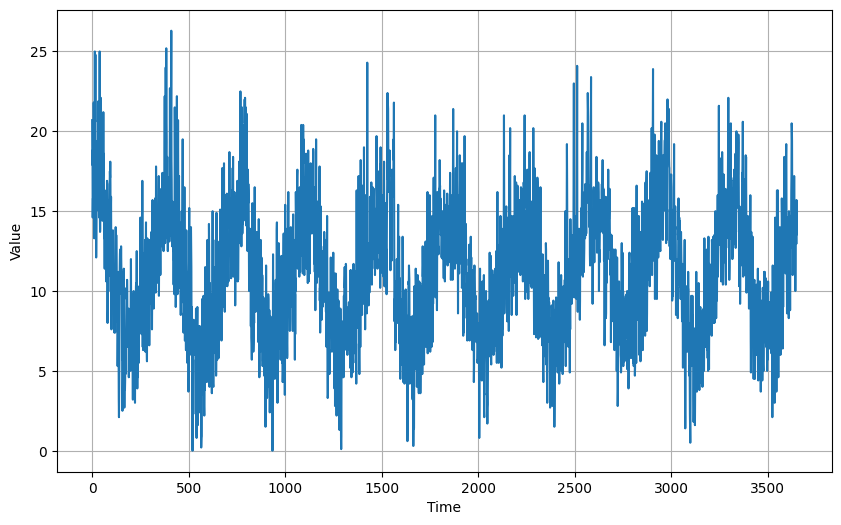

In [13]:

import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)


In [14]:

split_time = 3000

# Get the train set 
time_train = time[:split_time]# YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE

# Get the validation set
time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [15]:


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
    

In [16]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)



<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
(3000,)


2023-12-28 16:11:37.896119: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-28 16:11:37.896152: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-28 16:11:37.896166: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-28 16:11:37.896209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-28 16:11:37.896226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.legacy.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])




In [21]:

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100


2023-12-28 16:12:51.238608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 50ms/step - loss: 28.3750 - mae: 28.8750 - lr: 1.0000e-08
Epoch 2/100
 1/12 [=>............................] - ETA: 1s - loss: 28.4136 - mae: 28.9136

2023-12-28 16:12:52.407718: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9332627073037422762
2023-12-28 16:12:52.407730: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3583155273691894472
2023-12-28 16:12:52.407733: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10429118290448491152
2023-12-28 16:12:52.407736: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10139648204824136758
2023-12-28 16:12:52.407740: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10853985528147660039
2023-12-28 16:12:52.407752: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13586408153766299096
2023-12-28 16:12:52.407761: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

12/12 [==============================] - 1s 38ms/step - loss: 28.2003 - mae: 28.7003 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 37ms/step - loss: 27.9441 - mae: 28.4441 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 37ms/step - loss: 27.6396 - mae: 28.1396 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 37ms/step - loss: 27.2929 - mae: 27.7929 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 37ms/step - loss: 26.9021 - mae: 27.4021 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 34ms/step - loss: 26.4630 - mae: 26.9630 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 34ms/step - loss: 25.9692 - mae: 26.4692 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 0s 36ms/step - loss: 25.4148 - mae: 25.9148 - lr: 2.5119e-08
Epoch 10/100
12/12 [==============================] - 0s 35ms/step - loss: 24.7920 - mae: 25.2920 - 

(1e-08, 0.0001, 0.0, 35.0)

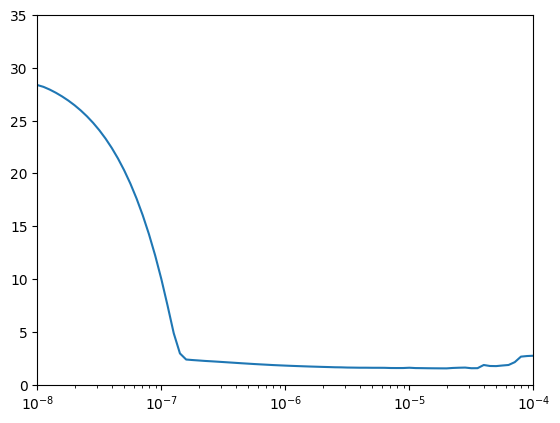

In [30]:

# ax.set_xscale("log", matplotlib.scale.LogScale)

plt.semilogx(history.history["lr"], history.history["loss"])

# Set the plot boundaries
plt.axis([1e-8, 1e-4, 0, 35])


In [33]:
import gc
del model, optimizer, history
gc.collect()


14897

In [ ]:

Looks like we can set the learning_rate during training to be approx. 3.16e-7 or 3.16*10^-7


In [34]:

# Reset states generated by Keras
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 3.16e-7

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])



In [35]:

# Train the model
history = model.fit(train_set, epochs=100)

#Can see some improvement (as the loss has gone down) after changing the learning_rate value


Epoch 1/100
12/12 [==============================] - 2s 48ms/step - loss: 5.9710 - mae: 6.4578
Epoch 2/100
 3/12 [======>.......................] - ETA: 0s - loss: 4.6859 - mae: 5.1686

2023-12-28 16:37:32.060843: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9332627073037422762
2023-12-28 16:37:32.060857: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3583155273691894472
2023-12-28 16:37:32.060869: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10429118290448491152
2023-12-28 16:37:32.060876: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13586408153766299096
2023-12-28 16:37:32.060880: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13197595804931716427
2023-12-28 16:37:32.060885: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10853985528147660039


12/12 [==============================] - 1s 37ms/step - loss: 4.3412 - mae: 4.8211
Epoch 3/100
12/12 [==============================] - 0s 34ms/step - loss: 4.3181 - mae: 4.7905
Epoch 4/100
12/12 [==============================] - 1s 37ms/step - loss: 4.1948 - mae: 4.6707
Epoch 5/100
12/12 [==============================] - 0s 35ms/step - loss: 4.1104 - mae: 4.5877
Epoch 6/100
12/12 [==============================] - 0s 35ms/step - loss: 4.0446 - mae: 4.5205
Epoch 7/100
12/12 [==============================] - 0s 34ms/step - loss: 3.9916 - mae: 4.4666
Epoch 8/100
12/12 [==============================] - 1s 37ms/step - loss: 3.9403 - mae: 4.4152
Epoch 9/100
12/12 [==============================] - 1s 38ms/step - loss: 3.8888 - mae: 4.3636
Epoch 10/100
12/12 [==============================] - 0s 34ms/step - loss: 3.8384 - mae: 4.3129
Epoch 11/100
12/12 [==============================] - 0s 34ms/step - loss: 3.7934 - mae: 4.2675
Epoch 12/100
12/12 [==============================] - 0s 34m

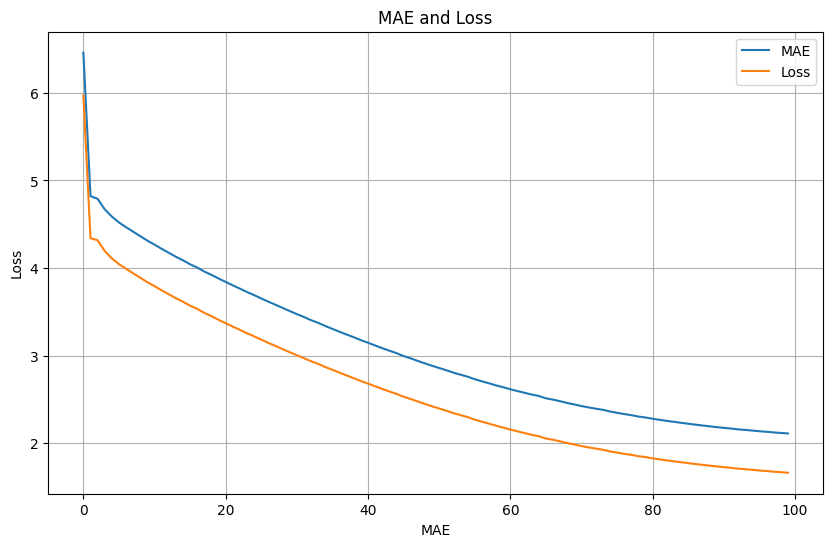

In [39]:



# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series_1(x=epochs, y=(mae, loss), title='MAE and Loss', xlabel='MAE', ylabel='Loss', legend=['MAE', 'Loss'])




In [40]:

int(epochs[-1] * 0.2)


19

In [44]:
epochs[-1]*0.4

39.6

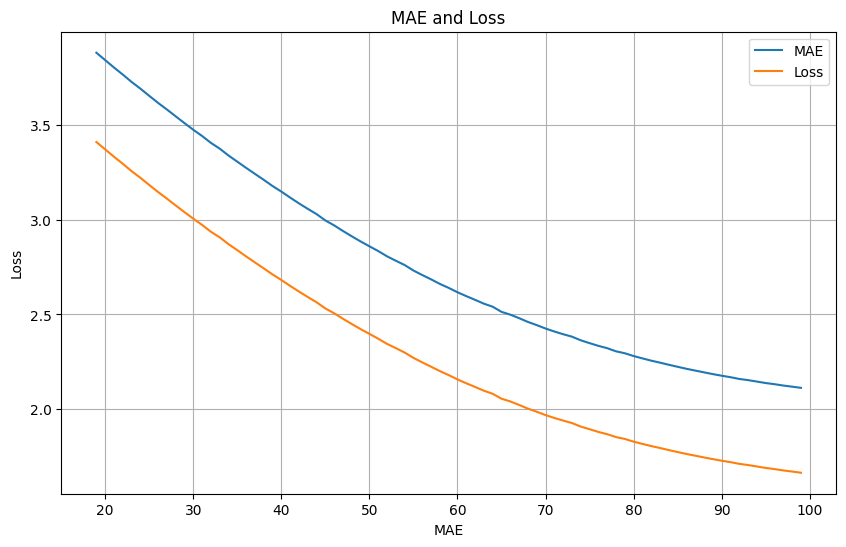

In [42]:


# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series_1(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )


In [67]:
del zoom_split, epochs_zoom, mae_zoom, loss_zoom

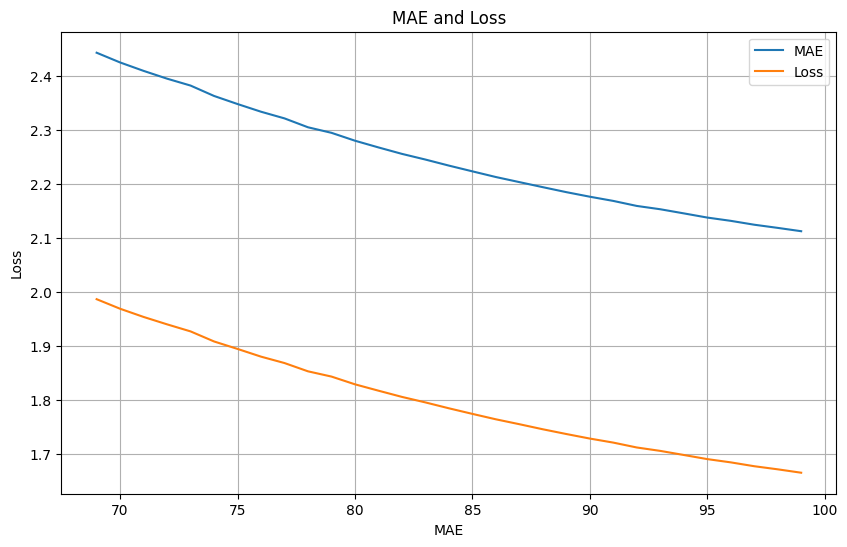

In [48]:

# Only plot the last % of the epochs
zoom_split = int(epochs[-1] * 0.7)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series_1(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )



In [50]:

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast



In [51]:
series

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [53]:

forecast.shape


(650, 1)

In [54]:

time_valid.shape


(650,)

In [55]:

x_valid.shape


(650,)

In [57]:

forecast.squeeze().shape


(650,)

3/3 [==============================] - 0s 19ms/step


2023-12-28 17:03:20.540233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11590957293360616296


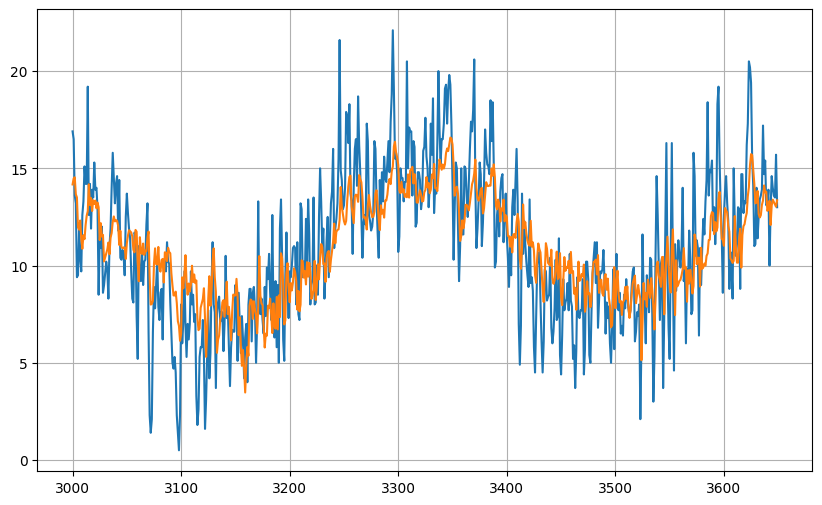

In [60]:

# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series_1(time_valid, (x_valid, results))
# plot_series_1(time_valid, x_valid)
# plot_series_1(time_valid, results)


In [66]:

max(x_valid), max(results)


(22.1, 16.582516)

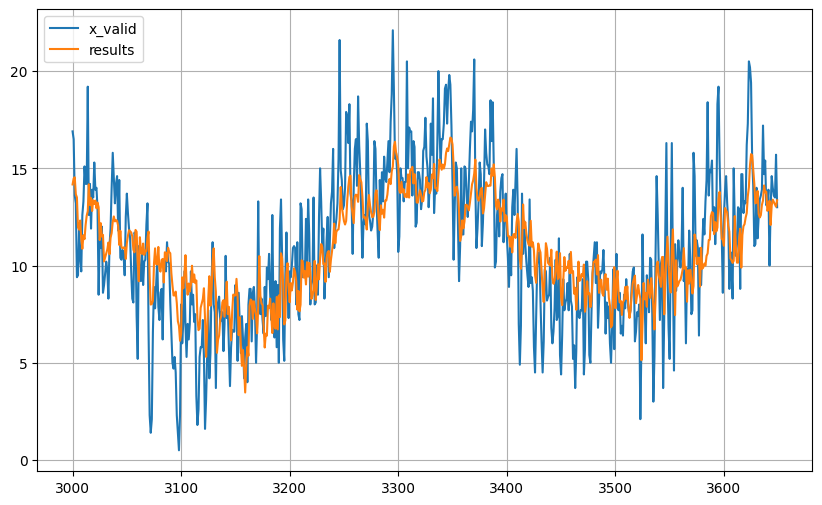

In [64]:
#Passing in the legend to know the plotted values

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series_1(time_valid, (x_valid, results), legend=['x_valid', 'results'])
# plot_series_1(time_valid, x_valid)
# plot_series_1(time_valid, results)



In [61]:

# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())


1.9732177


In [62]:

print(results)


[14.170906  14.473027  14.539751  13.664396  13.50654   11.963981
 11.847296  12.317335  11.414598  10.862711  11.558026  11.357435
 12.087126  12.562238  12.797308  14.179915  13.111795  13.471868
 12.806056  13.361123  13.164738  13.34073   12.944529  13.236804
 13.00002   11.30845   12.177669  11.485245  11.578987  10.209672
 10.418257  10.622701  10.829263  11.182872  10.582395  11.433326
 11.674438  12.249097  12.526205  12.271378  12.335862  12.300709
 12.042244  11.05824   11.787721  10.946643  10.8896885 10.934954
 10.923461  10.342065  11.160133  11.535392  11.815175  11.759065
 11.705312  11.498408  10.813548  10.681846  11.832476  11.74064
 10.162197   9.193981  11.456398  10.686524  10.597682  11.131409
 10.544998  10.765756  10.738198  11.44273   11.749037   9.4181185
  7.993643   8.023764   8.184409  10.102541  10.88502   10.069658
 10.053629  10.957485   9.808754   9.688517  10.288489  10.340388
  9.129099  10.679869  10.659864  10.229738  10.91211   10.697054
 10.632296


## Have to work on this to improve and check further whether the model is overfitting or not.


In [68]:

del results, model, history, forecast_series, forecast, df
gc.collect()


30095